# 주가지수만들기
--------------
<STEP 1>
   1. TCI 지수 선정 : 일일 확진자(과거데이터 가중치{EMA,MA등 사용}, 거리두기 단계(1~4단계), Additional Wieghted_Value : 누적사망자/누적확진자)
   > (누적사망자/누적확진자) 가 클수록 코로나의 위험도가 증가한다고 판단하여 가중치 값으로 선정
   2. TCI 지수와 코스피, 코스닥 움직임 상관관계 예측
---------------
<STEP 2>
   1. TCI 지수 산출을 위한 데이터 만들기 ('2020.03.10' ~ '2022.02.28')
   > 지수 산출방법 : ```(추가로더적을 부분)``` 4번까지 한다음에 다시 피드백해서 정하기
   2. 코스피, 코스닥 동기간 종가 불러오기
   3. 임의로 만든 TCI와 KOSPI & KOSDAQ 상관관계 비교
   4. 산업군별로 데이터분석
      > 상관성 높은 산업군에서 예측모델 사용권장
      ``예측은 아마도 헬스케어는 + , 운송업은 -``

In [45]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
from datetime import datetime
from scipy import interpolate

import warnings
warnings.filterwarnings('ignore')

In [46]:
# Assign Corona.csv to df
df = pd.read_csv('./datasets/Corona.csv')
dist = pd.read_excel('./datasets/Dist.xlsx')
Unemp = pd.read_excel('./datasets/실업자.xlsx')
imp_p = pd.read_excel('./datasets/해외여행객 입국 현황.xlsx')
exp_p = pd.read_excel('./datasets/해외여행객 출국 현황.xlsx')

ccsi = pd.read_excel('./datasets/CCSI.xlsx')
csi = pd.read_excel('./datasets/CSI.xlsx')
esi = pd.read_excel('./datasets/ESI.xlsx')
nsi = pd.read_csv('./datasets/NSI.csv')

# Preprocessing Corona Data

In [47]:
# Preprocessing Corona Data
df.columns = ["1", 'Date', 'DeadCnt', 'ConfirmedCnt', "2", "3", "4", "5", "6", "7"]
dist.columns = ['Date', 'Level']
df.drop([str(i) for i in range(1,8)],axis=1,inplace=True) # Drop Unecessary Columns
df = df.sort_values('Date') # Sorting DATE
df['DailyDeadCnt'] = (df['DeadCnt']-df['DeadCnt'].shift(1)).fillna(0) # Create DailyDeadCnt by using difference & fill NAN by 0
df['DailyConfirmedCnt'] = (df['ConfirmedCnt']-df['ConfirmedCnt'].shift(1)).fillna(0) # Create DailyConfirmedCnt by using difference & fill NAN by 0
df['D/C(%)'] = (df['DeadCnt']/df['ConfirmedCnt'])*100 # Create D/C
df.drop(['DeadCnt','ConfirmedCnt'],axis=1,inplace=True) # Drop Unecessary Columns
df.reset_index(drop=True, inplace=True) # Reset index
df['Date'] = df['Date'].str[0:4] + "-" + df['Date'].str[5:7] + "-" +df['Date'].str[8:10] # Change Date style YYYY-MM-DD
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True) # Change datatype from object to datetime

# Add Corona Level
df = pd.merge(df, dist, left_on='Date', right_on='Date', how = 'left') # Merge df & Corona Level
df.fillna(3, inplace=True) # ALL NAN index in Level column fill 3

# Add Number of Unemployed
Unemp['Date'] = pd.to_datetime(Unemp['Date']) # Change datatype from object to datetime
df = pd.merge(df, Unemp, left_on='Date', right_on='Date', how='left') # Merge Unemp & df
df['Num'] = df['Num'].interpolate(method='values') # Interpolate Num

# Add CSI, ESI, NSI
# csi['Date'] = pd.to_datetime(csi['Date']) # Change datatype from object to datetime
# df = pd.merge(df, csi, left_on='Date', right_on='Date', how='left') # Merge csi & df
# esi['Date'] = pd.to_datetime(esi['Date']) # Change datatype from object to datetime
# df = pd.merge(df, esi, left_on='Date', right_on='Date', how='left') # Merge esi & df
# nsi['Date'] = pd.to_datetime(nsi['Date']) # Change datatype from object to datetime
# nsi.drop('Unnamed: 0', axis=1, inplace=True)
# df = pd.merge(df, nsi, left_on='Date', right_on='Date', how='left') # Merge nsi & df

# df.iloc[:,6:13] = df.iloc[:,6:13].interpolate(method='values') # Interpolate Num

ccsi.columns = ['Date', 'CSI']
ccsi['Date'] = pd.to_datetime(ccsi['Date']) # Change datatype from object to datetime
df = pd.merge(df, ccsi, left_on='Date', right_on='Date', how='left') # Merge ccsi & df
df['CSI'] = df['CSI'].interpolate(method='values') # Interpolate Num

imp_p.columns = ['Date', 'Imp_p']
imp_p['Date'] = pd.to_datetime(imp_p['Date']) # Change datatype from object to datetime
df = pd.merge(df, imp_p, left_on='Date', right_on='Date', how='left') # Merge imp_p & df
df['Imp_p'] = df['Imp_p'].interpolate(method='values') # Interpolate Num

exp_p.columns = ['Date', 'Exp_p']
exp_p['Date'] = pd.to_datetime(exp_p['Date']) # Change datatype from object to datetime
df = pd.merge(df, exp_p, left_on='Date', right_on='Date', how='left') # Merge exp_p & df
df['Exp_p'] = df['Exp_p'].interpolate(method='values') # Interpolate Num

df.bfill(inplace=True)
df.ffill(inplace=True)

df['IEP'] = df['Imp_p'] + df['Exp_p']
df.drop(['Imp_p','Exp_p'], axis=1, inplace=True)


In [48]:
df

,Date,DailyDeadCnt,DailyConfirmedCnt,D/C(%),Level,Num,CSI,IEP
0,2020-03-10,0.0,0.0,0.718754,3.0,1172.0,72.5,60840.0
1,2020-03-11,6.0,242.0,0.773694,3.0,1172.0,72.5,60840.0
2,2020-03-12,6.0,114.0,0.838734,3.0,1172.0,72.5,60840.0
3,2020-03-13,1.0,110.0,0.839704,3.0,1172.0,72.5,60840.0
4,2020-03-14,5.0,107.0,0.890428,3.0,1172.0,72.5,60840.0
...,...,...,...,...,...,...,...,...
715,2022-02-24,82.0,170015.0,0.307660,2.0,954.0,103.1,212721.0
716,2022-02-25,94.0,165887.0,0.292037,2.0,954.0,103.1,212721.0
717,2022-02-26,112.0,166201.0,0.278850,2.0,954.0,103.1,212721.0
718,2022-02-27,49.0,163555.0,0.265257,2.0,954.0,103.1,212721.0


# Preprocessing stock index

In [49]:
# Read_csv
Kospi = pd.read_csv('./datasets/Kospi.csv')
Kodaq = pd.read_csv(('./datasets/Kodaq.csv'))
Bio = pd.read_csv(('./datasets/Bio.csv'))
Hc = pd.read_csv(('./datasets/Hc.csv'))
Trans = pd.read_csv(('./datasets/Trans.csv'))
Multi_Index = pd.read_csv('./datasets/makeup_travel_flight_index.csv')

In [50]:
# Change Columns Name
Bio.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'TA']
Hc.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'TA']
Trans.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'TA']
Multi_Index.columns = ['Date', 'MakeUp', 'Trav', 'Flight']

In [51]:
Target_list_df = [Kospi, Kodaq, Bio, Hc, Trans, Multi_Index]
for i, col in enumerate(Target_list_df):
    col['Date'] = pd.to_datetime(col['Date'],infer_datetime_format=True)
    col.set_index('Date', inplace=True)

In [52]:
# Preprocessing
df_c = df
sp_str = ['Kospi', 'Kosdq', 'Bio', 'Hc', 'Trans']
sp_df = [Kospi, Kodaq, Bio, Hc, Trans]

for i, col in enumerate(sp_df): # Merge Kospi & Kodaq into df_c
    corona_df = pd.merge(df_c, col['Close'], left_on='Date', right_on=col.index, how='inner')
    corona_df.rename(columns={'Close': sp_str[i]}, inplace=True)
    df_c = corona_df

corona_df = pd.merge(corona_df, Multi_Index, left_on='Date', right_on=Multi_Index.index, how='left')


In [53]:
Feature = corona_df.iloc[:,0:8]
Target = corona_df.drop(corona_df.columns[1:8], axis=1)

In [71]:
Feature

,Date,DailyDeadCnt,DailyConfirmedCnt,D/C(%),Level,Num,CSI,IEP,DCC_ewm
0,2020-03-10,0.0,0.0,0.718754,3.0,1172.0,72.5,60840.0,99.015807
1,2020-03-11,6.0,242.0,0.773694,3.0,1172.0,72.5,60840.0,148.523710
2,2020-03-12,6.0,114.0,0.838734,3.0,1172.0,72.5,60840.0,101.785566
3,2020-03-13,1.0,110.0,0.839704,3.0,1172.0,72.5,60840.0,95.678349
4,2020-03-16,0.0,74.0,0.910636,3.0,1172.0,72.5,60840.0,88.517523
...,...,...,...,...,...,...,...,...,...
481,2022-02-22,58.0,99569.0,0.347958,2.0,954.0,103.1,212721.0,140563.037915
482,2022-02-23,99.0,171442.0,0.326597,2.0,954.0,103.1,212721.0,166105.476923
483,2022-02-24,82.0,170015.0,0.307660,2.0,954.0,103.1,212721.0,162313.736842
484,2022-02-25,94.0,165887.0,0.292037,2.0,954.0,103.1,212721.0,155382.600000


In [72]:
Target

,Date,Kospi,Kosdq,Bio,Hc,Trans,MakeUp,Trav,Flight
0,2020-03-10,1962.93,619.97,11270.82,1858.70,322.68,100.000000,100.000000,100.000000
1,2020-03-11,1908.27,595.61,10922.04,1793.62,316.62,96.118677,97.676370,94.855061
2,2020-03-12,1834.33,563.49,10699.76,1737.73,302.03,92.076097,93.664807,92.992054
3,2020-03-13,1771.44,524.00,10294.39,1680.65,288.50,89.719209,89.940557,88.394324
4,2020-03-16,1714.86,504.51,9938.91,1637.77,281.53,86.267448,86.985016,88.732979
...,...,...,...,...,...,...,...,...,...
481,2022-02-22,2706.79,868.11,14426.68,1875.71,351.60,92.263887,114.531552,222.765865
482,2022-02-23,2719.53,877.33,14356.23,1869.15,354.78,90.281243,114.286422,222.092614
483,2022-02-24,2648.80,848.21,13942.52,1809.53,349.75,88.793598,111.526504,214.808985
484,2022-02-25,2676.76,872.98,14258.51,1855.85,353.15,87.717297,113.498320,215.704264


# EWM

In [73]:
df_reversed = Feature.sort_index(ascending=False)
df_reversed = df_reversed.assign(DCC_ewm=df_reversed['DailyConfirmedCnt'].ewm(span=5).mean())
Feature = Feature.assign(DCC_ewm=df_reversed['DCC_ewm'])
cd_p = Feature

# Corr

In [74]:
cc = Feature.iloc[:,1:]
cr = cc.corr()
cr

,DailyDeadCnt,DailyConfirmedCnt,D/C(%),Level,Num,CSI,IEP,DCC_ewm
DailyDeadCnt,1.000000,0.562670,-0.578671,-0.108192,-0.014187,0.331951,0.501286,0.553472
DailyConfirmedCnt,0.562670,1.000000,-0.397775,-0.038542,-0.114850,0.157247,0.235224,0.986987
D/C(%),-0.578671,-0.397775,1.000000,-0.335290,0.530730,-0.636363,-0.796515,-0.413974
Level,-0.108192,-0.038542,-0.335290,1.000000,-0.481807,0.114910,0.302860,-0.043703
Num,-0.014187,-0.114850,0.530730,-0.481807,1.000000,-0.403894,-0.661244,-0.120767
CSI,0.331951,0.157247,-0.636363,0.114910,-0.403894,1.000000,0.820493,0.164833
IEP,0.501286,0.235224,-0.796515,0.302860,-0.661244,0.820493,1.000000,0.247349
DCC_ewm,0.553472,0.986987,-0.413974,-0.043703,-0.120767,0.164833,0.247349,1.000000


# LogScale

In [56]:
cd_p = np.log1p(cd_p.iloc[:,1:])

In [57]:
cd_p = pd.DataFrame(cd_p)

In [58]:
# cd_p['DCC_ewm'] = cd_p['DCC_ewm'] * cd_p['Level']
# cd_p.drop('Level', axis=1)

# Train & Test

In [59]:
from sklearn.model_selection import train_test_split
import reg_model
import score_model
from imp import reload
reload(reg_model)
reload(score_model)

corona_feature1 = cd_p[['D/C(%)','CSI', 'DCC_ewm']] # Select features to delete Multicollinearity
corona_feature2 = cd_p[cd_p.columns[1:].drop(['DailyConfirmedCnt','Num'])]
corona_target = Target['Flight'] # Select target

sample = []
for i in range(2):
    globals()[f'X_train{i+1}, X_test{i+1}, y_train{i+1}, y_test{i+1}'] = train_test_split(globals()[f'corona_feature{i+1}'], corona_target, test_size=0.3, random_state=0)
    sample.append(globals()[f'X_train{i+1}, X_test{i+1}, y_train{i+1}, y_test{i+1}'])

In [60]:
# Assign Module
rg = reg_model.RegALL()
sm = score_model.ScoreALL()

* Multiple Regression Pred & Score For Single Index

In [61]:
# Create Regression pred & score 
pred_list_df = []
score_list_df = []
FI_list_df = []
pred_list = []
score_list = []
FI_list_name = ['RFR', 'XGBR']
reg_list = ['linreg', 'Logreg', 'Las', 'Rid', 'Elastic', 'RFR', 'XGBR']
rgm = [rg.Linreg, rg.Logreg, rg.Las, rg.Rid, rg.Elastic, rg.RFR, rg.XGBR]
for j in range(2):
    for i,name in enumerate(reg_list): # Chose Number of Sample
        globals()[f'pred_{reg_list[i]}'], globals()[f'score_{reg_list[i]}'] = rgm[i](sample[j][0], sample[j][1], sample[j][2], pred=True, score=True)

        pred_list.append(globals()[f'pred_{reg_list[i]}'])
        score_list.append(globals()[f'score_{reg_list[i]}'])

    fit_RFR = rg.RFR(sample[j][0], sample[j][1], sample[j][2], feature_importances_=True)
    fit_XGBR = rg.XGBR(sample[j][0], sample[j][1], sample[j][2], feature_importances_=True)
    FI_list_df.append([fit_RFR, fit_XGBR])
        
    pred_list_df.append(pred_list)
    score_list_df.append(score_list)
    pred_list = []
    score_list = [] 

In [62]:
# Listing for scoring
pred_list_name = ['pred_linreg', 'pred_Logreg', 'pred_Las', 'pred_Rid', 'pred_Elastic', 'pred_RFR', 'pred_XGBR']

# r2_score, explained_variance_score  
for j in range(2): # Chose Number of Sample   
    for i in range(len(pred_list_name)):
        print(f"\n <{pred_list_name[i]} #{j+1}>")
        sm.r2_(sample[j][3],pred_list_df[j][i])
        sm.evs_(sample[j][3],pred_list_df[j][i])
        print(f'{pred_list_name[i]} score : {score_list_df[j][i]}')


 <pred_linreg #1>
r2_score : 0.8515
explained_variance_score : 0.8549
pred_linreg score : 0.857

 <pred_Logreg #1>
r2_score : 0.4944
explained_variance_score : 0.5909
pred_Logreg score : 0.0735

 <pred_Las #1>
r2_score : 0.7366
explained_variance_score : 0.7405
pred_Las score : 0.7462

 <pred_Rid #1>
r2_score : 0.8028
explained_variance_score : 0.8074
pred_Rid score : 0.8222

 <pred_Elastic #1>
r2_score : 0.5606
explained_variance_score : 0.5668
pred_Elastic score : 0.6102

 <pred_RFR #1>
r2_score : 0.9922
explained_variance_score : 0.9925
pred_RFR score : 0.9983

 <pred_XGBR #1>
r2_score : 0.9916
explained_variance_score : 0.9918
pred_XGBR score : 1.0

 <pred_linreg #2>
r2_score : 0.8509
explained_variance_score : 0.8553
pred_linreg score : 0.8805

 <pred_Logreg #2>
r2_score : 0.5246
explained_variance_score : 0.6121
pred_Logreg score : 0.0971

 <pred_Las #2>
r2_score : 0.7559
explained_variance_score : 0.7580
pred_Las score : 0.7641

 <pred_Rid #2>
r2_score : 0.8195
explained_varian

* feature_importances_

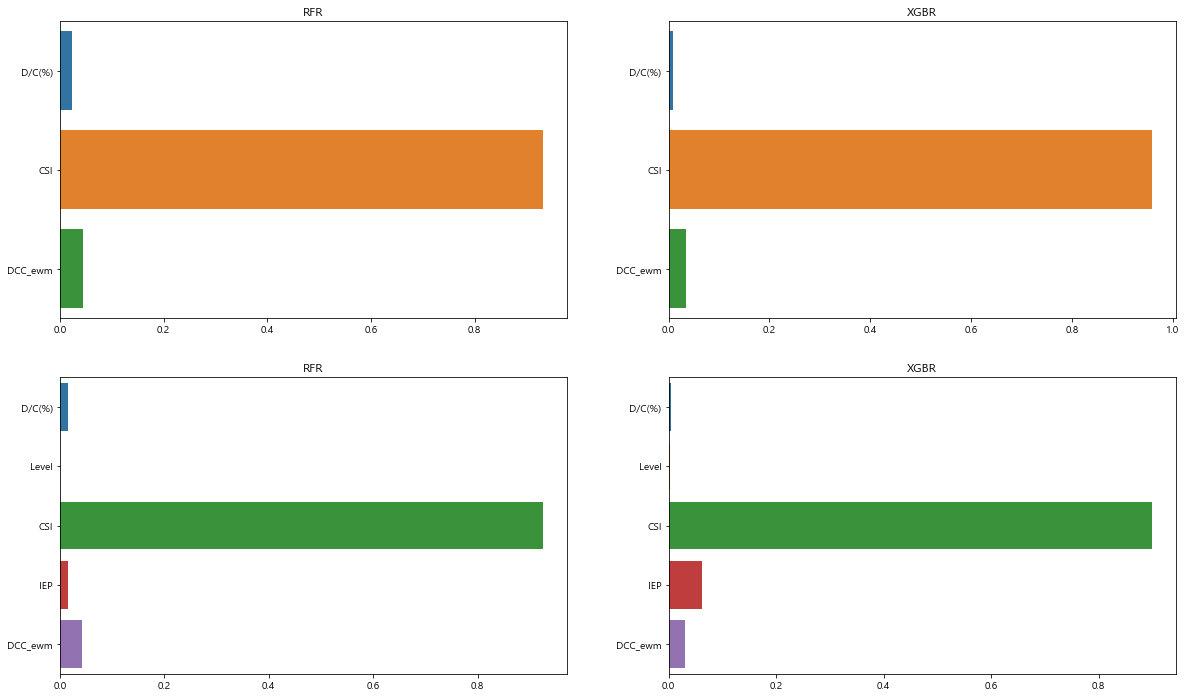

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

fig, axes = plt.subplots(nrows=len(FI_list_df), ncols=len(FI_list_df[0]),figsize=(20,12), facecolor='w')

for i in range(len(FI_list_df)):
    for j in range(len(FI_list_df[0])):
        importances_values = FI_list_df[i][j].feature_importances_
        importances = pd.Series(importances_values, index = sample[i][0].columns)
        
        sns.barplot(x=importances_values, y=importances.index, ax=axes[i][j]).set_title(FI_list_name[j])

plt.savefig('./compare2.png')


In [64]:
Target.columns[1:]

Index(['Kospi', 'Kosdq', 'Bio', 'Hc', 'Trans', 'MakeUp', 'Trav', 'Flight'], dtype='object')

* Single Regression Pred & Score For Multiple Index

In [65]:
corona_feature = cd_p[['D/C(%)','CSI', 'DCC_ewm']]
sample = []
corona_target = Target.iloc[:,1:]
for i in range(len(corona_target.columns)):
    X_train, X_test, y_train, y_test = train_test_split(corona_feature, corona_target.iloc[:,i], test_size=0.3, random_state=0)
    sample.append([X_train, X_test, y_train, y_test])

# Create Regression pred & score
pred_list_df = []
score_list_df = []
FI_list_df = []
for i in range(len(corona_target.columns)): # Chose Number of Sample
    pred_linreg, score_linreg = rg.Linreg(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)
    # pred_Logreg, score_Logreg = rg.Logreg(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)
    # pred_Las, score_Las = rg.Las(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)
    # pred_Rid, score_Rid = rg.Rid(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)
    # pred_Elastic, score_Elastic = rg.Elastic(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)
    # pred_RFR, score_RFR = rg.RFR(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)
    # pred_XGBR, score_XGBR = rg.XGBR(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)

    pred_list_df.append(pred_linreg)
    score_list_df.append(score_linreg)

    # pred_list_df.append([pred_linreg, pred_Logreg, pred_Las, pred_Rid, pred_Elastic, pred_RFR, pred_XGBR])
    # score_list_df.append([score_linreg, score_Logreg, score_Las, score_Rid, score_Elastic, score_RFR, score_XGBR])

    fit_RFR = rg.RFR(sample[i][0], sample[i][1], sample[i][2], feature_importances_=True)
    fit_XGBR = rg.XGBR(sample[i][0], sample[i][1], sample[i][2], feature_importances_=True)

    FI_list_df.append([fit_RFR, fit_XGBR])

# Listing for scoring
pred_list_name = ['pred_linreg']
# pred_list_name = ['pred_linreg', 'pred_Logreg', 'pred_Las', 'pred_Rid', 'pred_Elastic', 'pred_RFR', 'pred_XGBR']

# r2_score, explained_variance_score  
for j in range(len(corona_target.columns)): # Chose Number of Sample   
    for i in range(len(pred_list_name)):
        print(f" <{corona_target.columns[j]}>")
        sm.r2_(sample[j][3],pred_list_df[j])
        # sm.evs_(sample[j][3],pred_list_df[j])
        print(f'{pred_list_name[i]} score : {score_list_df[j]}')

 <Kospi>
r2_score : 0.8560
pred_linreg score : 0.8245
 <Kosdq>
r2_score : 0.8404
pred_linreg score : 0.8076
 <Bio>
r2_score : 0.5180
pred_linreg score : 0.3
 <Hc>
r2_score : 0.4432
pred_linreg score : 0.2515
 <Trans>
r2_score : 0.7847
pred_linreg score : 0.7034
 <MakeUp>
r2_score : 0.5047
pred_linreg score : 0.4414
 <Trav>
r2_score : 0.6916
pred_linreg score : 0.6407
 <Flight>
r2_score : 0.8515
pred_linreg score : 0.857


* Deleting Unnecessary Index(Bio, HC, MakeUp)

In [66]:
corona_feature = cd_p[['D/C(%)','CSI', 'DCC_ewm']]
sample = []
corona_target = Target[['Kospi', 'Kosdq', 'Trans', 'Trav', 'Flight']]
for i in range(len(corona_target.columns)):
    X_train, X_test, y_train, y_test = train_test_split(corona_feature, corona_target.iloc[:,i], test_size=0.3, random_state=0)
    sample.append([X_train, X_test, y_train, y_test])

# Create Regression pred & score
pred_list_df = []
score_list_df = []
FI_list_df = []
for i in range(len(corona_target.columns)): # Chose Number of Sample
    pred_linreg, score_linreg = rg.Linreg(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)
    # pred_Logreg, score_Logreg = rg.Logreg(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)
    # pred_Las, score_Las = rg.Las(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)
    # pred_Rid, score_Rid = rg.Rid(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)
    # pred_Elastic, score_Elastic = rg.Elastic(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)
    # pred_RFR, score_RFR = rg.RFR(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)
    # pred_XGBR, score_XGBR = rg.XGBR(sample[i][0], sample[i][1], sample[i][2], pred=True, score=True)

    pred_list_df.append(pred_linreg)
    score_list_df.append(score_linreg)

    # pred_list_df.append([pred_linreg, pred_Logreg, pred_Las, pred_Rid, pred_Elastic, pred_RFR, pred_XGBR])
    # score_list_df.append([score_linreg, score_Logreg, score_Las, score_Rid, score_Elastic, score_RFR, score_XGBR])

    fit_RFR = rg.RFR(sample[i][0], sample[i][1], sample[i][2], feature_importances_=True)
    fit_XGBR = rg.XGBR(sample[i][0], sample[i][1], sample[i][2], feature_importances_=True)

    FI_list_df.append([fit_RFR, fit_XGBR])

# Listing for scoring
pred_list_name = ['pred_linreg']
# pred_list_name = ['pred_linreg', 'pred_Logreg', 'pred_Las', 'pred_Rid', 'pred_Elastic', 'pred_RFR', 'pred_XGBR']

# r2_score, explained_variance_score  
for j in range(len(corona_target.columns)): # Chose Number of Sample   
    for i in range(len(pred_list_name)):
        print(f" <{corona_target.columns[j]}>")
        sm.r2_(sample[j][3],pred_list_df[j])
        # sm.evs_(sample[j][3],pred_list_df[j])
        print(f'{pred_list_name[i]} score : {score_list_df[j]}')

 <Kospi>
r2_score : 0.8560
pred_linreg score : 0.8245
 <Kosdq>
r2_score : 0.8404
pred_linreg score : 0.8076
 <Trans>
r2_score : 0.7847
pred_linreg score : 0.7034
 <Trav>
r2_score : 0.6916
pred_linreg score : 0.6407
 <Flight>
r2_score : 0.8515
pred_linreg score : 0.857


# Conclusion

In [67]:
Target_c = pd.concat([corona_target,Feature[['D/C(%)','CSI','DCC_ewm','IEP']]],axis=1)
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
Target_scaled = mm.fit_transform(Target_c)
Target_c_scaled = pd.DataFrame(Target_scaled, columns=Target_c.columns)

In [68]:
Target_c_scaled['TCI_1'] =  (Target_c_scaled['DCC_ewm'] * 0.4) - (Target_c_scaled['CSI'] * 0.6)
Target_c_scaled['TCI_2'] = (Target_c_scaled['D/C(%)'] * 0.1) - (Target_c_scaled['CSI'] * 0.6) + (Target_c_scaled['DCC_ewm'] * 0.3)

Target_c_scaled.drop(['D/C(%)','CSI','DCC_ewm','IEP'],inplace=True,axis=1)
Target_c_scaled

,Kospi,Kosdq,Trans,Trav,Flight,TCI_1,TCI_2
0,0.273489,0.303364,0.403546,0.463222,0.195154,0.000217,0.021743
1,0.243904,0.264799,0.375349,0.427657,0.169922,0.000336,0.024400
2,0.203884,0.213948,0.307463,0.366255,0.160786,0.000224,0.027356
3,0.169845,0.151429,0.244510,0.309252,0.138238,0.000209,0.027390
4,0.139221,0.120573,0.212079,0.264014,0.139898,0.000192,0.030693
...,...,...,...,...,...,...,...
481,0.676104,0.696208,0.538107,0.685643,0.797222,-0.147227,-0.227600
482,0.683000,0.710805,0.552903,0.681891,0.793920,-0.085714,-0.182465
483,0.644717,0.664704,0.529499,0.639648,0.758200,-0.094846,-0.190198
484,0.659851,0.703918,0.545319,0.669829,0.762591,-0.111538,-0.203448


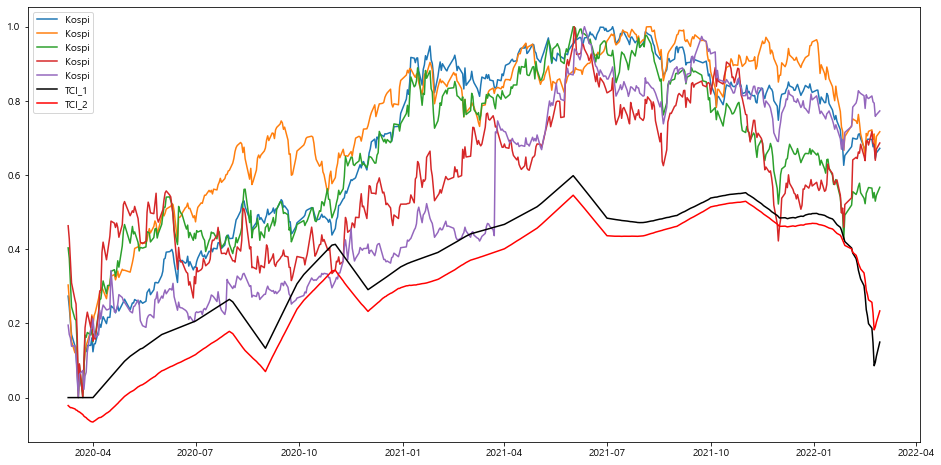

In [69]:
plt.figure(figsize=(16,8), facecolor='w')
for i in range(len(Target_c_scaled.columns[:5])):  
    plt.plot(Feature['Date'], Target_c_scaled.iloc[:,i], label = Target_c_scaled.columns[0])
plt.plot(Feature['Date'], Target_c_scaled['TCI_1'] * (-1), label = 'TCI_1', color = 'black')
plt.plot(Feature['Date'], Target_c_scaled['TCI_2'] * (-1), label = 'TCI_2', color = 'red')

plt.legend()

In [76]:
ccc = Target_c_scaled.corr()
ccc

,Kospi,Kosdq,Trans,Trav,Flight,TCI_1,TCI_2
Kospi,1.000000,0.956166,0.947495,0.839564,0.849896,-0.904397,-0.912241
Kosdq,0.956166,1.000000,0.880529,0.766348,0.821869,-0.897504,-0.903769
Trans,0.947495,0.880529,1.000000,0.876790,0.772279,-0.850909,-0.829168
Trav,0.839564,0.766348,0.876790,1.000000,0.870164,-0.785195,-0.800822
Flight,0.849896,0.821869,0.772279,0.870164,1.000000,-0.838818,-0.894298
TCI_1,-0.904397,-0.897504,-0.850909,-0.785195,-0.838818,1.000000,0.985583
TCI_2,-0.912241,-0.903769,-0.829168,-0.800822,-0.894298,0.985583,1.000000
